In [2]:
# Современные методы вычислительной математики и механики, 1 семестр, 2021 г.
# Лабораторная работа 2. Методы решения бигармонических уравнений: Метод КНК.
# Решение задачи методом итераций по подобластям.

import numpy as np
from numba import jit,njit 
from matplotlib import  pyplot as plt

######### Геометрические характеристики, глобальная сетка #############
X0 = 0.0; X1 = 1.0  # Левая/Правая граница
#Базис: Chebyshev или Monoms
Basis = 'Monoms'
######## Параметры ячейки, локальная сетка ############ 
N_degree = 4 # степень аппроксимирующего полинома
N_colloc = N_degree+1 # количество точек коллокации
N_eq = N_colloc + 4 # Количество уравнений в локальной матрице
eps_val = 1e-14 # псевдопогрешность
# распределение точек в ячейке в локальной системе координат
if(Basis == 'Monoms'):
    y_ = np.linspace(-1., 1., N_colloc+2, endpoint = True)
if(Basis == 'Chebyshev'):
    y_ = np.array([-np.cos(i / (N_colloc+1) * np.pi) for i in range(0, N_colloc+2)])

# правая часть уравнения в ячейке cell_id в точке с локальной координатой y
@njit
def f(x):
    return np.exp(x)
    #return (x**4 + 14*x**3 + 49*x**2 + 32*x - 12)*np.exp(x)

# Точное решение
@njit
def u_exact(x):
    #u = x**2*(1-x)**2*np.exp(x)  
    return np.exp(x)

# функция краевого условия
@njit
def boundary_func(x):
    #return 0
    return np.exp(x)

@njit
def der_boundary_func(x):
    #return 0
    return np.exp(x)

@njit
def polynomial(degree, y):
    if(Basis == 'Monoms'):
        return y**degree
    if(Basis == 'Chebyshev'):
        if(degree == 0):
            return 1
        elif(degree == 1):
            return y
        else:
            return 2*y*polynomial(degree - 1, y) - polynomial(degree - 2, y)

@njit
def der1_polynomial(degree, y):
    if(Basis == 'Monoms'):
        if(degree >= 1):
            return degree*y**(degree - 1)
        else:
            return 0
    if(Basis == 'Chebyshev'):
        if(degree == 0):
            return 0
        elif(degree == 1):
            return 1
        else:
            return 2*y*der1_polynomial(degree - 1, y) - der1_polynomial(degree - 2, y) + 2*polynomial(degree - 1, y)

@njit
def der2_polynomial(degree, y):
    if(Basis == 'Monoms'):
        if(degree >= 2):
            return degree*(degree - 1) * y**(degree - 2)
        else:
            return 0
    if(Basis == 'Chebyshev'):
        if(degree == 0):
            return 0
        elif(degree == 1):
            return 0
        else:
            return 2*y*der2_polynomial(degree - 1, y) - der2_polynomial(degree - 2, y) + 2*2*der1_polynomial(degree - 1, y)

@njit
def der3_polynomial(degree, y):
    if(Basis == 'Monoms'):
        if(degree >= 3):
            return degree*(degree - 1) * (degree - 2) * y**(degree - 3)
        else:
            return 0
    if(Basis == 'Chebyshev'):
        if(degree == 0):
            return 0
        elif(degree == 1):
            return 0
        else:
            return 2*y*der3_polynomial(degree - 1, y) - der3_polynomial(degree - 2, y) + 2*3*der2_polynomial(degree - 1, y)

@njit
def der4_polynomial(degree, y):
    if(Basis == 'Monoms'):
        if(degree >= 4):
            return degree*(degree - 1) *(degree - 2)*(degree - 3)* y**(degree - 4)
        else:
            return 0
    if(Basis == 'Chebyshev'):
        if(degree == 0):
            return 0
        elif(degree == 1):
            return 0
        else:
            return 2*y*der4_polynomial(degree - 1, y) - der4_polynomial(degree - 2, y) + 2*4*der3_polynomial(degree - 1, y)

# Вычисление решения по найденным коэффициентам
@njit
def u(x, Matrix, GlobalNodes):
    # переход в локальную систему  
    h = (GlobalNodes[1] - GlobalNodes[0])/2
    
    if (x == X0):
        cell_id = 0
    elif (x == X1):
        cell_id = len(GlobalNodes) - 2
    else:
        cell_id = int(x // (2*h)) 

    x_c = (GlobalNodes[cell_id] + GlobalNodes[cell_id+1])/2
    y = (x-x_c)/h # перешли в локальную систему в нужной ячейке
    # вычисляем значение искомой функции в точке y
    ans = sum([Matrix[cell_id, i]*polynomial(i, y) for i in range(N_degree+1)])
    return ans

In [3]:
# функция заполнения левой  граничной ячейки
@njit
def left_cell():
    Matrix = np.zeros((N_eq, N_degree + 1))
    # условия согласования
    Matrix[-2] = [polynomial(j, y_[-1]) + der1_polynomial(j, y_[-1]) for j in range(N_degree+1)]
    Matrix[-1] = [der2_polynomial(j, y_[-1]) + der3_polynomial(j, y_[-1]) for j in range(N_degree+1)]
    # условия коллокации
    for i in range(2, N_colloc+2):
        Matrix[i][4:N_degree+1] = [der4_polynomial(j, y_[i-1]) for j in range(4, N_degree+1)]
    # граничные условия
    Matrix[0] = [polynomial(j, y_[0]) for j in range(N_degree+1)]
    Matrix[1] = [der1_polynomial(j, y_[0]) for j in range(N_degree+1)]
    return Matrix

# функция заполнения правой  граничной ячейки
@njit
def right_cell():
    Matrix = np.zeros((N_eq, N_degree + 1))
    # граничные условия
    Matrix[-2] = [polynomial(j, y_[-1]) for j in range(N_degree+1)]
    Matrix[-1] = [der1_polynomial(j, y_[-1]) for j in range(N_degree+1)]
    # условия согласования
    Matrix[0] = [polynomial(j, y_[0]) - der1_polynomial(j, y_[0]) for j in range(N_degree+1)]
    Matrix[1] = [der2_polynomial(j, y_[0]) - der3_polynomial(j, y_[0]) for j in range(N_degree+1)]
    # условия коллокаций 
    for i in range(2, N_colloc+2):
        Matrix[i][4:N_degree+1] = [der4_polynomial(j, y_[i-1]) for j in range(4, N_degree+1)]
    return Matrix
    
# функция заполнения центральной регулярной ячейки
@njit
def inner_cell():
    Matrix = np.zeros((N_eq, N_degree + 1))
    # условия согласования
    Matrix[-2] = [polynomial(j, y_[-1]) + der1_polynomial(j, y_[-1]) for j in range(N_degree+1)]
    Matrix[-1] = [der2_polynomial(j, y_[-1]) + der3_polynomial(j, y_[-1]) for j in range(N_degree+1)]
    # условия согласования
    Matrix[0] = [polynomial(j, y_[0]) - der1_polynomial(j, y_[0]) for j in range(N_degree+1)]
    Matrix[1] = [der2_polynomial(j, y_[0]) - der3_polynomial(j, y_[0]) for j in range(N_degree+1)]
    # условия коллокаций 
    for i in range(2, N_colloc+2):
        Matrix[i][4:N_degree+1] = [der4_polynomial(j, y_[i-1]) for j in range(4, N_degree+1)]
    return Matrix
    
# функция заполнения вектора правой части
@njit
def rhs(cell_id, Matrix, step, Global_Nodes):
    LocalVector = np.zeros(N_eq)
    # проверка, какого типа ячейка
    if (cell_id == 0):
        # граничные условия
        LocalVector[0] = boundary_func(X0)
        LocalVector[1] = der_boundary_func(X0)*(step/2)
        # условия согласования
        LocalVector[-2] = sum([Matrix[cell_id+1, j]*polynomial(j, -1) + Matrix[cell_id+1, j]*der1_polynomial(j, -1) for j in range(N_degree+1)])
        LocalVector[-1] = sum([Matrix[cell_id+1, j]*der2_polynomial(j, -1) + Matrix[cell_id+1, j]*der3_polynomial(j, -1)  for j in range(N_degree+1)])
    elif(cell_id == len(Global_Nodes)-2):
        # условия согласования
        LocalVector[0] = sum([Matrix[cell_id-1, j]*polynomial(j, 1) - Matrix[cell_id-1, j]*der1_polynomial(j, 1) for j in range(N_degree+1)])
        LocalVector[1] = sum([Matrix[cell_id-1, j]*der2_polynomial(j, 1) - Matrix[cell_id-1, j]*der3_polynomial(j, 1)  for j in range(N_degree+1)])
        # граничные условия
        LocalVector[-2] = boundary_func(X1)
        LocalVector[-1] = der_boundary_func(X1)*(step/2)
    else:
        # условия согласования
        LocalVector[0] = sum([Matrix[cell_id-1, j]*polynomial(j, 1) - Matrix[cell_id-1, j]*der1_polynomial(j, 1) for j in range(N_degree+1)])
        LocalVector[1] = sum([Matrix[cell_id-1, j]*der2_polynomial(j, 1) - Matrix[cell_id-1, j]*der3_polynomial(j, 1) for j in range(N_degree+1)])
        # условия согласования
        LocalVector[-2] = sum([Matrix[cell_id+1, j]*polynomial(j, -1) + Matrix[cell_id+1, j]*der1_polynomial(j, -1) for j in range(N_degree+1)])
        LocalVector[-1] = sum([Matrix[cell_id+1, j]*der2_polynomial(j, -1) + Matrix[cell_id+1, j]*der3_polynomial(j, -1) for j in range(N_degree+1)])
    # правая часть в точках коллокации  
    xc = (Global_Nodes[cell_id] + Global_Nodes[cell_id + 1])/2
    x = np.array([y_[i] * step / 2 + xc for i in range(1, N_colloc+1)])
    LocalVector[2:-2] = (step/2)**4*f(x)
    # возвращаем полученный вектор
    return LocalVector

In [32]:
# QR разложение отражениями хаусхолдера

def qr_householder(A):
    A = A.copy().astype(float)
    m, n = A.shape
    u_vectors = []

    for k in range(n):
        x = A[k:, k]
        norm_x = np.linalg.norm(x)
        if norm_x == 0:
            u_vectors.append(np.zeros_like(x))
            continue
        
        if x[0] >= 0:
            sgn = 1
        else:
            sgn = -1
            
        v = x + sgn * norm_x * np.eye(len(x))[0]
        u = v / np.linalg.norm(v)
        u_vectors.append(u)

        # Применяем отражение Хаусхолдера только к подматрице A[k:, k:]
        A[k:, k:] -= 2 * np.outer(u, np.dot(u.T, A[k:, k:]))

        # Сохраняем u под диагональю
        A[k+1:, k] = u[1:]

    # R (n x n)
    R = np.triu(A[:n, :])

    # Полная Q (m x m)
    Q_full = np.eye(m)
    for k in range(n - 1, -1, -1):
        u = u_vectors[k]
        Q_full[k:, :] -= 2 * np.outer(u, np.dot(u.T, Q_full[k:, :]))

    # Reduced Q (m x n) как np.linalg.qr(A)
    Q = Q_full[:, :n]

    return Q, R

In [ ]:
# настройка вывода
np.set_printoptions(linewidth=300, threshold = 1e6, precision = 3)

# функция решения системы в зависимости от количества ячеек
# менять настройки внутри ячейки можно только через глобальные переменные в начале скрипта
def Iterations_over_subdomain(N_cells):
    step = (X1-X0)/N_cells # Длина одной ячейки

    # Создаем массив узлов (границы ячеек) 
    GlobalNodes = np.linspace(X0, X1, N_cells+1) 

    CoeffMatrix = np.zeros((N_cells, N_degree+1), dtype = np.float64) # матрица коэффициентов для всех ячеек
    CoeffMatrix_old = np.zeros((N_cells, N_degree+1), dtype = np.float64) # матрица коэффициентов для хранения

    #создаем локальную  матрицу для центральной ячейки
    A_inner = inner_cell()
    # создаем локальную  матрицу для левой граничной ячейки
    A_left = left_cell()
    # создаем локальную  матрицу для правой граничной ячейки
    A_right = right_cell()

    # Находим QR разложение локальных матриц (reduced QR: Q (m,n), R (n,n))
    Q_inner, R_inner = qr_householder(A_inner)
    Q_left, R_left = qr_householder(A_left)
    Q_right, R_right = qr_householder(A_right)

    # Находим обратные для матриц R
    R_inner_inv = np.linalg.inv(R_inner)
    R_left_inv = np.linalg.inv(R_left)
    R_right_inv = np.linalg.inv(R_right)

    # Считаем числа обусловленности локальной и граничных матриц
    Cond_A_inner = np.linalg.cond(A_inner)
    Cond_A_left = np.linalg.cond(A_left)

    N_iter = 0
    eps = 1
    # заполняем матрицу коэффициентов начальным приближением    
    CoeffMatrix.fill(0.4)
    
     # цикл пока псевдопогрешность больше заданного значения
    while (eps > eps_val):
        # копируем матрицу коэффициентов
        CoeffMatrix_old = np.copy(CoeffMatrix)
        # обходим ячейки по порядку
        for i in range(N_cells):
            # проверка на тип ячейки
            if (i==0):
                # обновляем вектор правой части
                F_ = rhs(i, CoeffMatrix, step, GlobalNodes)
                # находим коэффициенты
                CoeffMatrix[i] = np.dot(R_left_inv, np.dot(Q_left.T, F_))  
            elif (i==N_cells-1):
                F_ = rhs(i, CoeffMatrix, step, GlobalNodes)
                CoeffMatrix[i] = np.dot(R_right_inv, np.dot(Q_right.T, F_))
            else:
                F_ = rhs(i, CoeffMatrix, step, GlobalNodes)
                CoeffMatrix[i] = np.dot(R_inner_inv, np.dot(Q_inner.T, F_))

        # обновляем значения псевдопогрешности
        eps = np.max(np.abs(CoeffMatrix - CoeffMatrix_old))

        N_iter = N_iter + 1

    print("Cells = ", N_cells, "Solution converged at Iteration: ", N_iter, "Eps:", eps)

    # Возвращаем массив в следующей последовательности: коэффициенты, узлы, кол-во итераций, обсуловленность центральной ячейки, обусл. гр. ячейки.
    return CoeffMatrix, GlobalNodes, N_iter, Cond_A_inner, Cond_A_left

In [63]:
# Отрисовка решения
def plot_solution(Solution, K):
    # достаточно мелкая сетка, для сравнения решений и отрисовки
    X_cor = np.arange(X0, X1, 0.01)
    # значение численного решения сетке
    u_ = np.array([u(i, Solution[0], Solution[1]) for i in X_cor])
    # значение точного решения на сетке
    u_ex = np.array([u_exact(i) for i in X_cor])
    # рисуем численное решение
    fig = plt.figure(figsize=(12,8), frameon=True)
    plt.style.use('ggplot')
    plt.rcParams["mathtext.fontset"] = "cm"
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['font.size'] = 25
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['xtick.color'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    plt.rcParams['axes.labelcolor'] = 'black'
    ax = fig.add_subplot(111)    

    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')

    ax.set(facecolor='w')
    ax.grid('axis = "both"', color = 'gray')

    ax.set_xlabel('$\\varepsilon$', labelpad = -10)
    ax.set_ylabel('$\\sigma$', rotation = 0, labelpad = 20)

    ax.plot(X_cor, u_, color = 'blue', linestyle = '-', linewidth = 3, label=f'Решение МКНК при K = {K}')
    #ax.plot(w_obr, P_obr, color = 'red', linestyle = '-', label = 'obrabotannoe')
    ax.plot(X_cor, u_ex, color = 'red', linestyle = '-', linewidth = 2, label = 'Точное решение')
    ax.legend(loc=2)

    plt.show()
    fig.savefig(f'LSCM_K={K}.jpg', dpi = 300)

In [43]:
import time
# решаем задачу на последовательности сеток, начиная с 5

i=5
ans = Iterations_over_subdomain(i)
Solution_array = [ ]
error = []
error_abs = []
time_list = []
X_cor = np.linspace(X0, X1, 100)
u_ex = np.array([u_exact(i) for i in X_cor])

# засекаем время
start = time.time() 
cur_time = start       
while i < 81:
    # решаем задачу
    ans = Iterations_over_subdomain(i)
    print("Time in seconds:", time.time()-cur_time)
    time_list.append(np.round(time.time()-cur_time, 2))
    cur_time = time.time()
    # сохраняем решение в массив решений
    Solution_array.append(ans)
    # восстанавливаем решение
    u_ = np.array([u(i, ans[0], ans[1]) for i in X_cor])
    # вычисляем погрешность
    error_abs.append(np.max(abs(u_-u_ex)))  
    error.append(np.max(abs(u_-u_ex))/np.max(abs(u_ex)))  
    i=i*2

Cells =  5 Solution converged at Iteration:  82 Eps: 8.881784197001252e-15
Cells =  5 Solution converged at Iteration:  82 Eps: 8.881784197001252e-15
Time in seconds: 0.005983591079711914
Cells =  10 Solution converged at Iteration:  278 Eps: 8.659739592076221e-15
Time in seconds: 0.023763656616210938
Cells =  20 Solution converged at Iteration:  1070 Eps: 7.771561172376096e-15
Time in seconds: 0.13370466232299805
Cells =  40 Solution converged at Iteration:  4299 Eps: 9.769962616701378e-15
Time in seconds: 1.0667943954467773
Cells =  80 Solution converged at Iteration:  17213 Eps: 9.992007221626409e-15
Time in seconds: 8.503039121627808


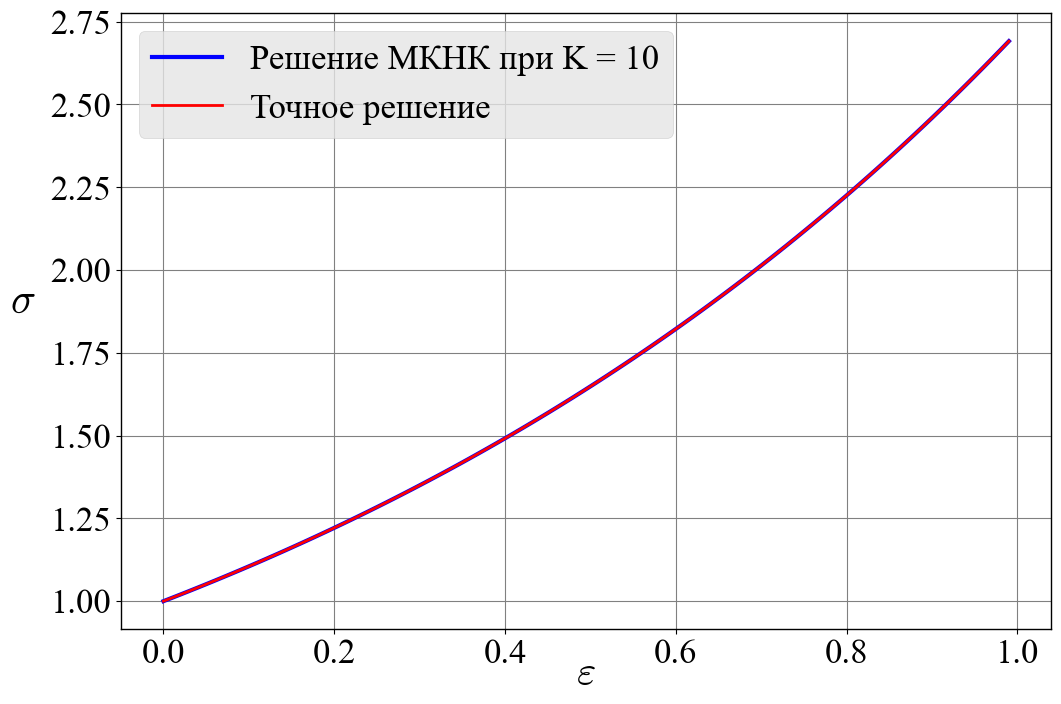

In [65]:
plot_solution(Solution_array[1], 10)

In [46]:
import pandas as pd

# Порядки сходимости
rate = [0.0]
rate_abs = [0.0]
for i in range(len(error) - 1):
    rate.append(np.log2(error[i] / error[i + 1]))
    rate_abs.append(np.log2(error_abs[i] / error_abs[i + 1]))

# DataFrame с результатами (числа остаются числами — удобно для экспорта в Excel)
df = pd.DataFrame({
    "Mesh": [5 * 2**i for i in range(len(error))],
    "Error_absolute": error_abs,
    "Order_abs": rate_abs,
    "Error_relative": error,
    "Order": rate,
    "Iteration": [Solution_array[i][2] for i in range(len(error))],
    "Cond_A_inner": [Solution_array[i][3] for i in range(len(error))],
    "Cond_A_left": [Solution_array[i][4] for i in range(len(error))],
    "Time_sec": time_list,
})

df

,Mesh,Error_absolute,Order_abs,Error_relative,Order,Iteration,Cond_A_inner,Cond_A_left,Time_sec
0,5,1.258158e-05,0.000000,4.628503e-06,0.000000,82,121.053755,69.765386,0.01
1,10,3.070495e-06,2.034770,1.129572e-06,2.034770,278,121.053755,69.765386,0.02
2,20,7.609393e-07,2.012618,2.799339e-07,2.012618,1070,121.053755,69.765386,0.13
3,40,1.898300e-07,2.003073,6.983455e-08,2.003073,4299,121.053755,69.765386,1.07
4,80,4.744167e-08,2.000481,1.745281e-08,2.000481,17213,121.053755,69.765386,8.50


In [48]:
df.to_excel("table1.xlsx")